<a href="https://colab.research.google.com/github/tonmelo12358/voo_mltraining/blob/main/Treinamento_Dataset_Voo_novo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Engenharia de Sistemas de Software Inteligentes - Wellington Melo
## Desenvolvimento de modelo - Voo - Satisfação de clientes nos voos

### Passo 1 - Configurações iniciais e imports do projeto

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # Converte cada valor de uma variável categórica em um número inteiro único
from sklearn.preprocessing import OneHotEncoder # Converte variáveis categóricas em um formato binário
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer # trabalhar com valores nulos
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

### Passo 2 - Carga do Dataset

O dataset contém informações sobre vários passageiros e suas experiências de voo, com cada registro representando uma pessoa. As variáveis incluem informações da pessoa , detalhes do voo e qualidade do serviço durante a viagem. A última coluna, Outcome, indica se o passageiro ficou safisteito (1) ou não (0).
O dataset é bem grande e possui diversas colunas. Para aplicação deste MVP estamos selecionando parte dessas colunas e também estamos limitando a quantidade de colunas analisadas/treinadas.

Descrição de Cada Coluna

- Age: idade (anos)
- Gender: Gênero (masculino / feminino).
- Customer Type: Tipo de passageiro (se é passageiro frequente ou eventual).
- Type of Travel: Tipo de viagem (Negócios ou passeio).
- Class: Classe que o passageiro viajou (Executiva / Economica ou economica plus).
- Flight Distance: Distância percorrida no voo (em milhas).
- Seat comfort: Pontuação que o passageiro deu para o assento (1 a 5).
- Inflight entertainment: Pontuação que o passageiro deu para o serviço de entretenimento no voo (1 a 5).
- Checkin service: Pontuação que o passageiro deu para o serviço de checkin da companhia aérea (1 a 5).
- Inflight service: Pontuação que o passageiro deu para o serviço de bordo do voo (1 a 5).
- Cleanliness: Pontuação que o passageiro deu para a limpeza da aeronave (1 a 5).
- Departure Delay in Minutes: Atraso no embarque (minutos)
- Arrival Delay in Minutes: Atraso no desembarque (minutos)
- Satisfaction (Outcome): Resultado (0 ou 1) indicando a satisfação (1) ou insatisfação (0) na experiência do voo.

Algumas informações possuem respostas em texto. ara realizar o treino será necessário transformar essas colunas, fazendo com que o dataset de treino possua outras colunas.
Segue as modificações necessárias:
- Gender: Gênero >> Gender_Male / Gender_Female
- Customer Type >> Customer Type_Loyal Customer / Customer Type_desloyal Customer
- Type of Travel >> Type of Travel_Business Travel / Type of Travel_Personal Travel
- Class >> Class_Business / Class_Eco / Class_Eco Plus

O objetivo é prever se um passageiro ficou satisfeito ou não baseado em suas informações sobre a viagem que realizou.

In [2]:
# Informa a URL de importação do dataset
src = "https://raw.githubusercontent.com/tonmelo12358/voo_mltraining/refs/heads/main/voo_training.csv"

# Lê o arquivo
dataset = pd.read_csv(src, delimiter=',')

# Seleciona as colunas desejadas
selected_columns = [
    "Gender", "Customer Type", "Age", "Type of Travel", "Class", "Flight Distance",
    "Seat comfort", "Inflight entertainment", "Checkin service", "Inflight service",
    "Cleanliness", "Departure Delay in Minutes", "Arrival Delay in Minutes", "satisfaction"
]  # Selecionando apenas colunas principais

dataset = dataset[selected_columns]

# Conversão de variáveis categóricas em numéricas usando One-Hot Encoding
dataset = pd.get_dummies(dataset, columns=["Gender", "Customer Type", "Type of Travel", "Class"])

# Converte a coluna 'satisfaction' para valores numéricos
dataset['satisfaction'] = dataset['satisfaction'].map({'satisfied': 1, 'neutral or dissatisfied': 0})

# Remover linhas com valores ausentes
dataset = dataset.dropna()

# Verificar se todas as colunas são numéricas
assert all([pd.api.types.is_numeric_dtype(dataset[col]) for col in dataset.columns]), "Nem todas as colunas são numéricas."

# Seleciona uma amostra de 10.000 linhas
dataset = dataset.sample(n=10000, random_state=42)

print(dataset['satisfaction'].value_counts())

# Mostra as primeiras linhas do dataset
dataset.head()



satisfaction
0    5578
1    4422
Name: count, dtype: int64


,Age,Flight Distance,Seat comfort,Inflight entertainment,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
20726,44,3306,4,4,3,4,5,0,0.0,1,False,True,True,False,True,False,True,False,False
10051,30,2979,2,2,1,4,2,0,0.0,0,True,False,True,False,True,False,True,False,False
6749,40,449,5,4,5,4,4,1,16.0,1,False,True,True,False,True,False,True,False,False
21322,50,1090,5,4,5,4,3,109,97.0,1,True,False,True,False,True,False,True,False,False
3036,58,2116,4,4,3,4,4,97,73.0,1,False,True,True,False,True,False,True,False,False


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 20726 to 8713
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              10000 non-null  int64  
 1   Flight Distance                  10000 non-null  int64  
 2   Seat comfort                     10000 non-null  int64  
 3   Inflight entertainment           10000 non-null  int64  
 4   Checkin service                  10000 non-null  int64  
 5   Inflight service                 10000 non-null  int64  
 6   Cleanliness                      10000 non-null  int64  
 7   Departure Delay in Minutes       10000 non-null  int64  
 8   Arrival Delay in Minutes         10000 non-null  float64
 9   satisfaction                     10000 non-null  int64  
 10  Gender_Female                    10000 non-null  bool   
 11  Gender_Male                      10000 non-null  bool   
 12  Customer Type_Loyal 

### Passo 3 - Separação em conjunto de treino e conjunto de teste com holdout

Realiza a preparação dos dados para treinar um modelo de aprendizado de máquina.

In [4]:
# Definição de tamanho de conjunto de teste e semente
test_size = 0.20  # Tamanho do conjunto de teste
seed = 7  # Semente aleatória

# Separação em conjuntos de treino e teste
X = dataset.drop(columns=["satisfaction"]).values  # Todas as colunas menos o rótulo
y = dataset["satisfaction"].values  # Apenas a coluna de rótulo

# Divisão dos dados em conjunto de treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y
)

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed)  # Validação cruzada com estratificação

# Verificar a distribuição de classes no conjunto de treino
train_class_distribution = pd.Series(y_train).value_counts()
print("Distribuição de classes no conjunto de treino:")
print(train_class_distribution)

# Verificar a distribuição de classes no conjunto de teste
test_class_distribution = pd.Series(y_test).value_counts()
print("Distribuição de classes no conjunto de teste:")
print(test_class_distribution)

Distribuição de classes no conjunto de treino:
0    4462
1    3538
Name: count, dtype: int64
Distribuição de classes no conjunto de teste:
0    1116
1     884
Name: count, dtype: int64


## Modelagem e Inferência

### Passo 4: Criação e avaliação de modelos: linha base

Esta sessão cria, avalia e compara vários modelos de classificação utilizando validação cruzada e pipelines de escalonamento para selecionar o melhor desempenho.

KNN: 0.861500 (0.006490)
CART: 0.820375 (0.015533)
NB: 0.796000 (0.011948)
SVM: 0.878875 (0.005433)
RF: 0.889125 (0.007787)
AdaBoost: 0.836625 (0.008330)
GB: 0.887625 (0.006649)
ET: 0.879125 (0.007666)


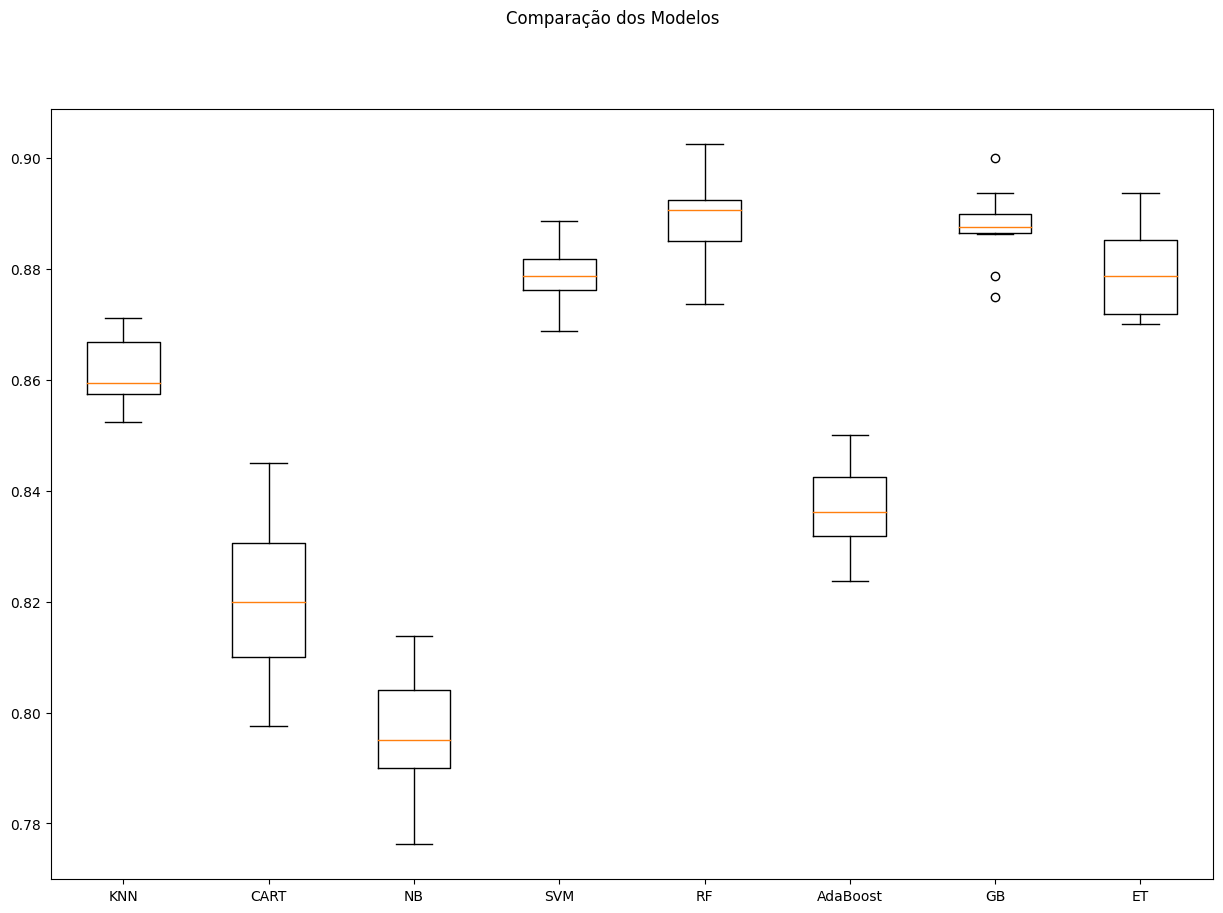

In [5]:
# Definir uma semente global para reprodutibilidade
np.random.seed(7)

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos com pipeline para escalonamento
models.append(('KNN', Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])))
models.append(('CART', DecisionTreeClassifier()))  # Árvore de decisão não precisa de escalonamento
models.append(('NB', GaussianNB()))  # Naive Bayes não precisa de escalonamento
models.append(('SVM', Pipeline([('scaler', StandardScaler()), ('svm', SVC())])))

# Ensembles
base_cart = DecisionTreeClassifier()  # Usado como base no Bagging
num_trees = 100  # Número de estimadores para os ensembles

# Adicionando ensembles na lista de modelos
models.append(('RF', RandomForestClassifier(n_estimators=num_trees)))
models.append(('AdaBoost', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos usando validação cruzada
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Passo 5: Criação e avaliação de modelos: dados padronizados e normalizados

Esta sessão cria, treina e avalia múltiplos modelos de classificação usando pipelines para comparar o desempenho em diferentes versões do dataset: original, padronizado e normalizado, através de validação cruzada.

KNN-orig: 0.624 (0.009)
CART-orig: 0.820 (0.016)
NB-orig: 0.796 (0.012)
SVM-orig: 0.653 (0.014)
RF-orig: 0.889 (0.008)
AdaBoost-orig: 0.837 (0.008)
GB-orig: 0.888 (0.007)
ET-orig: 0.879 (0.008)
KNN-padr: 0.862 (0.006)
CART-padr: 0.822 (0.014)
NB-padr: 0.796 (0.012)
SVM-padr: 0.879 (0.005)
RF-padr: 0.887 (0.009)
AdaBoost-padr: 0.837 (0.008)
GB-padr: 0.887 (0.007)
ET-padr: 0.878 (0.007)
KNN-norm: 0.862 (0.012)
CART-norm: 0.820 (0.015)
NB-norm: 0.796 (0.012)
SVM-norm: 0.869 (0.005)
RF-norm: 0.889 (0.011)
AdaBoost-norm: 0.837 (0.008)
GB-norm: 0.888 (0.007)
ET-norm: 0.878 (0.008)


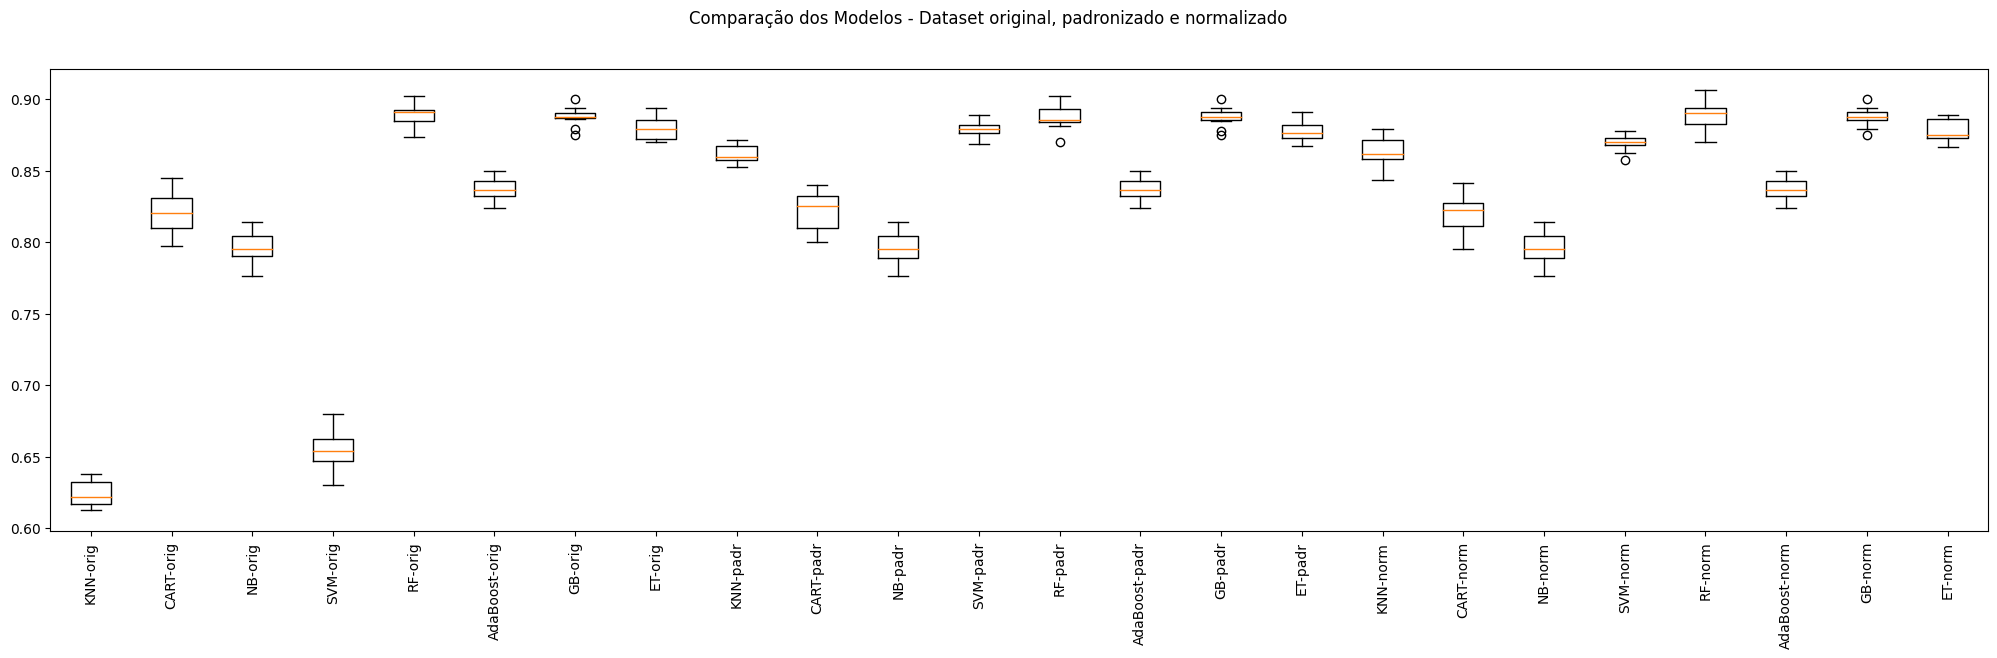

In [6]:
np.random.seed(7)  # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Ensembles que serão utilizados
num_trees = 100  # número de estimadores para os ensembles
rf = ('RF', RandomForestClassifier(n_estimators=num_trees))
ada = ('AdaBoost', AdaBoostClassifier(n_estimators=num_trees))
gb = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
et = ('ET', ExtraTreesClassifier(n_estimators=num_trees))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Ensembles no dataset original
pipelines.append(('RF-orig', Pipeline([rf])))
pipelines.append(('AdaBoost-orig', Pipeline([ada])))
pipelines.append(('GB-orig', Pipeline([gb])))
pipelines.append(('ET-orig', Pipeline([et])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Ensembles no dataset padronizado
pipelines.append(('RF-padr', Pipeline([standard_scaler, rf])))
pipelines.append(('AdaBoost-padr', Pipeline([standard_scaler, ada])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gb])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, et])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Ensembles no dataset normalizado
pipelines.append(('RF-norm', Pipeline([min_max_scaler, rf])))
pipelines.append(('AdaBoost-norm', Pipeline([min_max_scaler, ada])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gb])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, et])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())  # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25, 6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()



### Modelo escolhido: Random Forest padronizado

### Passo 6: Otimização dos hiperparâmetros

Esta sessão utiliza GridSearch para realizar uma busca por hiperparâmetros ideais de um modelo Random Forest, treinando e avaliando várias combinações para identificar a melhor configuração de acordo com a acurácia.

In [7]:
# TUNING DO RANDOM FOREST

# Definir a grade de hiperparâmetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Criar o modelo
rf = RandomForestClassifier()

# GridSearch para Random Forest
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Treinar o modelo com a otimização de hiperparâmetros
grid_search_rf.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
print("Melhores parâmetros para Random Forest:", grid_search_rf.best_params_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Melhores parâmetros para Random Forest: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


## Finalização do Modelo

### Passo 7: Preparação do Modelo

Modelo escolhido: Random Forest padronizado

Melhores parâmetros para Random Forest: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}

Esta sessão prepara o modelo escolhido com os melhores hiperparâmetros encontrados, aplica a padronização nos dados de treino e teste, treina o modelo com os dados normalizados e avalia sua performance no conjunto de teste, exibindo a acurácia e a importância das features para o modelo.


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train)  # Ajuste do scaler com o conjunto de treino
rescaledX_train = scaler.transform(X_train)  # Aplicação da padronização no conjunto de treino

# Definindo o Random Forest com os melhores parâmetros
model = RandomForestClassifier(
    n_estimators=300,  # Número de árvores na floresta
    criterion='entropy',  # Critério de divisão (entropia)
    max_depth=20,  # Profundidade máxima das árvores
    min_samples_split=5,  # Mínimo de amostras para dividir um nó
    min_samples_leaf=1,  # Mínimo de amostras em cada folha
    max_features='log2',  # Raiz quadrada do número de features usadas em cada nó
    random_state=42  # Semente para reprodutibilidade
)

# Treinando o modelo com os dados normalizados
model.fit(rescaledX_train, y_train)  # O modelo é treinado com o conjunto de treino normalizado

# Estimativa da acurácia no conjunto de teste
rescaledX_test = scaler.transform(X_test)  # O conjunto de teste é padronizado da mesma forma que o treino
predictions = model.predict(rescaledX_test)  # O modelo faz previsões no conjunto de teste

# Exibindo a acurácia do modelo no conjunto de teste
print("Acurácia no conjunto de teste:", accuracy_score(y_test, predictions))  # Exibe a acurácia no conjunto de teste

# Exibir a importância das features
importances = model.feature_importances_  # Importâncias das features de acordo com o Random Forest
indices = np.argsort(importances)[::-1]  # Ordena as features pela importância


Acurácia no conjunto de teste: 0.895


### Passo 8: Definição de Pipeline

Este sessão define um pipeline  de um modelo Random Forest, treinado com os hiperparâmetros. Após treinar o pipeline com os dados de treino, faz previsões no conjunto de teste e avalia o desempenho do modelo, exibindo a acurácia e um relatório de classificação para detalhar a performance em cada classe.

In [9]:
# Definir uma semente aleatória para consistência
np.random.seed(7)

# Definir um pipeline com escalonamento e Random Forest
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Etapa de escalonamento
    ('rf', RandomForestClassifier(
        n_estimators=300,        # Número de árvores na floresta
        criterion='entropy',     # Critério de divisão (entropia)
        max_depth=20,            # Profundidade máxima das árvores
        min_samples_split=5,     # Mínimo de amostras para dividir um nó
        min_samples_leaf=1,      # Mínimo de amostras em cada folha
        max_features='sqrt',     # Raiz quadrada do número de features usadas em cada nó
        random_state=42          # Semente para reprodutibilidade
    ))  # Modelo Random Forest com os melhores hiperparâmetros
])

# Treinamento do pipeline no conjunto de treino
pipeline.fit(X_train, y_train)

# Predição no conjunto de teste usando o pipeline
predictions = pipeline.predict(X_test)

# Estimativa da acurácia no conjunto de teste
print("Acurácia no conjunto de teste:", accuracy_score(y_test, predictions))

# Gera o relatório de classificação
report = classification_report(y_test, predictions, target_names=['neutral or dissatisfied', 'satisfied'])

# Exibir o relatório de classificação
print("Relatório de Classificação:")
print(report)


Acurácia no conjunto de teste: 0.895
Relatório de Classificação:
                         precision    recall  f1-score   support

neutral or dissatisfied       0.87      0.95      0.91      1116
              satisfied       0.93      0.82      0.87       884

               accuracy                           0.90      2000
              macro avg       0.90      0.89      0.89      2000
           weighted avg       0.90      0.90      0.89      2000



### Passo 9: Salvando

Esta seção realiza o salvamento do modelo, do scaler, pipeline e também os dados de teste separados entre features e outcomes.

In [ ]:
# Salvando o modelo do Random Forest
modelscaler_voo_rf = 'rf_voo_classifier.pkl'
with open("../models/" + modelscaler_voo_rf, 'wb') as file:
    pickle.dump(pipeline.named_steps['rf'], file)  # Salvando apenas o modelo Random Forest

# Salvando o scaler
scaler_voo_rf = 'minmax_scaler_voo.pkl'
with open("../scalers/" + scaler_voo_rf, 'wb') as file:
    pickle.dump(pipeline.named_steps['scaler'], file)  # Salvando apenas o scaler

# Salvando o pipeline completo
pipeline_voo_rf = 'rf_voo_pipeline.pkl'
with open("../pipelines/" + pipeline_voo_rf, 'wb') as file:
    pickle.dump(pipeline, file)  # Salvando o pipeline completo (com scaler e modelo)

# Salvando X_test e y_test
X_test_df = pd.DataFrame(X_test, columns=dataset.drop(columns=['satisfaction']).columns)  # todas as colunas, exceto satisfaction
y_test_df = pd.DataFrame(y_test, columns=['satisfaction'])  # nome da coluna alvo
X_test_df.to_csv("../data/X_test_dataset_voo.csv", index=False)
y_test_df.to_csv("../data/y_test_dataset_voo.csv", index=False)

print("Modelo, scaler, pipeline e dados de teste salvos com sucesso!")


Modelo, scaler, pipeline e dados de teste salvos com sucesso!


### Passo 10: Preparação com todo o dataset

Esta seção prepara e treina um modelo Random Forest utilizando o dataset completo para aproveitar ao máximo todas as amostras disponíveis e obter um modelo final mais robusto para produção.

In [ ]:
# Preparação do modelo com TODO o dataset

# Ajuste do scaler com TODO o dataset
scaler = StandardScaler().fit(X)  # Ajuste do scaler com o dataset completo
rescaledX = scaler.transform(X)  # Aplicação da padronização com TODO o dataset

# Treinamento do modelo Random Forest com todo o dataset e com os melhores hiperparâmetros encontrados
model = RandomForestClassifier(
    n_estimators=500,      # Número de árvores na floresta
    max_depth=20,          # Profundidade máxima das árvores
    min_samples_split=5,   # Mínimo de amostras para dividir um nó
    min_samples_leaf=1,    # Mínimo de amostras em cada folha
    max_features='sqrt',   # Número de features a serem consideradas em cada divisão
    random_state=7         # Semente aleatória para reprodutibilidade
)

# Ajuste do modelo Random Forest com o dataset padronizado
model.fit(rescaledX, y)


RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=500,
                       random_state=7)

### Passo 11: Simulando a aplicação do modelo em dados não vistos

In [ ]:
# Novos dados - não sabemos a classe!
data = {'Age':  [50, 29, 25],  # idade
        'Flight Distance': [120, 40, 2000],  # flight distance
        'Seat comfort': [1, 3, 5],  # seat comfort
        'Inflight entertainment': [1, 3, 5],  # inflight entertainment
        'Checkin service': [1, 3, 5],  # checkin service
        'Inflight service': [1, 3, 5],  # inflight service
        'Cleanliness': [1, 3, 5],  # cleanliness
        'Departure Delay in Minutes': [100, 10, 0],  # departure delay in minutes
        'Arrival Delay in Minutes': [100, 10, 0],  # arrival delay in minutes
        'Gender_Female': [1, 0, 0],  # gender female
        'Gender_Male': [0, 1, 1],  # gender male
        'Customer Type_Loyal Customer': [1, 1, 0],  # Customer Type loyal customer
        'Customer Type_disloyal Customer': [0, 0, 1],  # Customer Type disloyal customer
        'Type of Travel_Business travel': [1, 1, 0],  # Type of Travel business travel
        'Type of Travel_Personal Travel': [0, 0, 1],  # Type of Travel personal travel
        'Class_Business': [0, 0, 1],  # Class business
        'Class_Eco': [0, 1, 0],  # Class eco
        'Class_Eco Plus': [1, 0, 0],  # Class eco plus
        }

# Criação do DataFrame de entrada
atributos = ['Age', 'Flight Distance', 'Seat comfort', 'Inflight entertainment', 'Checkin service',
             'Inflight service', 'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
             'Gender_Female', 'Gender_Male', 'Customer Type_Loyal Customer', 'Customer Type_disloyal Customer',
             'Type of Travel_Business travel', 'Type of Travel_Personal Travel',
             'Class_Business', 'Class_Eco', 'Class_Eco Plus']

entrada = pd.DataFrame(data, columns=atributos)

# Converter para numpy array e transformar para float
X_entrada = entrada.values.astype(float)

# Padronização nos dados de entrada usando o scaler utilizado no pipeline
rescaledEntradaX = pipeline.named_steps['scaler'].transform(X_entrada)  # Reutiliza o scaler do pipeline

print("Dados de entrada escalonados:\n", rescaledEntradaX)

# Previsão de classes dos dados de entrada usando o modelo Random Forest treinado no pipeline
predictions = pipeline.predict(rescaledEntradaX)
print("Previsões para os novos dados:", predictions)


Dados de entrada escalonados:
 [[ 0.68275663 -1.06871907 -1.85164324 -1.76359797 -1.82798386 -2.23747831
  -1.74266538  2.40230477  2.38412046  0.97408566 -0.97408566  0.48471544
  -0.48471544  0.66304276 -0.66304276 -0.95596841 -0.90202422  3.54067494]
 [-0.70459083 -1.14902254 -0.33530114 -0.27115773 -0.25400142 -0.5510428
  -0.22705707 -0.12134552 -0.12824583 -1.02660376  1.02660376  0.48471544
  -0.48471544  0.66304276 -0.66304276 -0.95596841  1.10861768 -0.28243203]
 [-0.96884749  0.81841263  1.18104095  1.2212825   1.31998103  1.13539271
   1.28855124 -0.40175111 -0.40739764 -1.02660376  1.02660376 -2.06306611
   2.06306611 -1.50819836  1.50819836  1.04605967 -0.90202422 -0.28243203]]
Previsões para os novos dados: [0 0 0]


### Passo 12:

Esta seção realiza a predição de classes para novos dados de entrada usando o modelo treinado.pelo modelo em relação aos novos dados.

In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)

# Exibindo as previsões feitas pelo modelo
print("Previsões para os novos dados de entrada:", saidas)

Previsões para os novos dados de entrada: [0 0 0]


## Bloco Final - Análise dos Resultados

O tamanho do dataset é muito grande (3MB), e para tornar este MVP viável foram necessárias algumas diminuições na massa de dados analisada:
- Escolha de apenas algumas colunas para utilização;
- Diminuição do número de amostras (10k);
- Retirada de valores nulos dentro das colunas analisadas/treinadas.

Estas mudanças reduziram o tempo de treino e tornaram ele possível, mas trouxeram uma complexidade grande para o restante do código. Foram necessárias muitas horas de debug para conseguir chegar na utilização correta do modelo treinado.

Em relação aos modelos treinados, os que se saíram melhores para o conjunto de dados de voo foram os ensembles, particularmente Random Forest e Extra Trees, que demonstraram alta acurácia e consistência. A normalização ou padronização dos dados foi crucial para melhorar o desempenho de alguns modelos, especialmente SVM e KNN, mas ainda sim não tiveram um resultado tão bom.

Random Forester atingiu uma acurácia muito boa nos testes realizados. É interessante que é um ensemble que utiliza múltiplas árvores de decisão como base, e o modelo de ávore de decisão (CART) teve um resultado baixo se comparado ao Random Forester.

Este é o relatório do random Forester:

Acurácia no conjunto de teste: 0.896

Relatório de Classificação:



               accuracy  precision    recall  f1-score   support
         neutral/dissat       0.87      0.95      0.91      1116
              satisfied       0.90      0.90      0.88      884

               accuracy                           0.90      2000
              macro avg       0.90      0.89      0.89      2000
           weighted avg       0.90      0.90      0.90      2000

A precisão esteve mais alta em satisfied (0.6 de diferença), enquanto o recall esteve mais alto para neutral/dissatisfied e com diferença maior (0.12), tornando ele ligeiramente melhor em identificar passageiros "neutros ou insatisfeitos" do que identificar os "satisfeitos". De qualquer forma, o score f1 de 0,91/0,88 indica um bom equilíbrio entre as métricas.

A média das acurácias se manteve alta e estável.

As principais dificuldades encontradas neste trabalho foram em relação às transformações realizadas no dataset e a diferença entre a acurácia e os testes. A acurácia estava alta (>89%) mas os resultados dos testes aleatóricos não reproduziam esta acurácia. Foi necessário realizar um higienização no ambiente virtual, deletar todos os arquivos gerados pelo treino, criar novo env e rodar o treino novamente para conseguir verificar que o modelo estava funcionando.

Achei esta experiência de treino de modelo muito interessante pois meu conhecimento anterior sobre este tema era nulo. Ainda tenho diversas dúvidas mas esta atividade me ajudou a entender os fundamentos de ciência de dados e em como funcionam os modelos.
